In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [38]:
train_data = pd.read_csv('../DATASET/digit-recognizer/train.csv')
val_data = pd.read_csv('../DATASET/digit-recognizer/test.csv')

In [39]:
X = train_data.drop('label', axis=1)
y = train_data['label']


In [65]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Spliting Train Test Data

In [50]:
#split train test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=55)

## pre function

In [51]:
def view_image(data, index):
    image = data.iloc[index].values
    image = image.reshape((28,28))
    plt.imshow(image, cmap='gray')
    plt.title(data.iloc[index,0])
    plt.axis('off')
    plt.show()

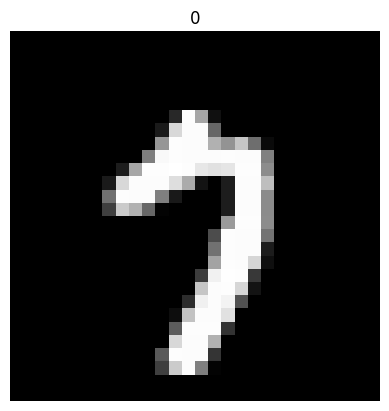

In [52]:
#Example
view_image(X_train, 0)

In [53]:
type(X_train)

pandas.core.frame.DataFrame

## Choosing model

#### randomforest with tuning

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
clf = RandomForestClassifier()
parameters = {'max_depth':[i for i in range(1,20,2)], 'n_estimators':[i for i in range(10,50,10)]}
clf = GridSearchCV(clf, parameters,cv=10, scoring='accuracy', verbose=10)

clf.fit(X_train, y_train)
print(clf.best_params_)

Fitting 10 folds for each of 40 candidates, totalling 400 fits
[CV 1/10; 1/40] START max_depth=1, n_estimators=10..............................
[CV 1/10; 1/40] END max_depth=1, n_estimators=10;, score=0.452 total time=   0.3s
[CV 2/10; 1/40] START max_depth=1, n_estimators=10..............................
[CV 2/10; 1/40] END max_depth=1, n_estimators=10;, score=0.439 total time=   0.1s
[CV 3/10; 1/40] START max_depth=1, n_estimators=10..............................
[CV 3/10; 1/40] END max_depth=1, n_estimators=10;, score=0.459 total time=   0.1s
[CV 4/10; 1/40] START max_depth=1, n_estimators=10..............................
[CV 4/10; 1/40] END max_depth=1, n_estimators=10;, score=0.448 total time=   0.1s
[CV 5/10; 1/40] START max_depth=1, n_estimators=10..............................
[CV 5/10; 1/40] END max_depth=1, n_estimators=10;, score=0.475 total time=   0.1s
[CV 6/10; 1/40] START max_depth=1, n_estimators=10..............................
[CV 6/10; 1/40] END max_depth=1, n_estima

KeyboardInterrupt: 

In [18]:
print(clf.best_score_)

0.9577114427860696


In [34]:
y_pred = clf.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [35]:
y_pred

array([8, 6, 2, ..., 8, 3, 3])

In [36]:
#evaluate model
from sklearn.metrics import precision_score
print(f"precision score (micro) = {precision_score(y_test, y_pred, average='micro')}")
print(f"precision score (macro) = {precision_score(y_test, y_pred, average='macro')}")
print(f"precision score (weighted) = {precision_score(y_test, y_pred, average='weighted')}")

precision score (micro) = 0.9559884559884559
precision score (macro) = 0.9556420502196328
precision score (weighted) = 0.9559496697827149


Score <br>
precision score (micro) = 0.9559884559884559 <br>
precision score (macro) = 0.9556420502196328 <br>
precision score (weighted) = 0.9559496697827149

#### Neural Network (pyTorch)

In [101]:
# convert data to dataloader
from torch.utils.data import DataLoader, TensorDataset
#1/4 to val sey
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=55)

torch_X_train = torch.FloatTensor(X_train.values).to(device)
torch_y_train = torch.LongTensor(y_train.values).to(device)

torch_X_val = torch.FloatTensor(X_val.values).to(device)
torch_y_val = torch.LongTensor(y_val.values).to(device)

torch_X_test = torch.FloatTensor(X_test.values).to(device)
torch_y_test = torch.LongTensor(y_test.values).to(device)

ds_X_train = TensorDataset(torch_X_train, torch_y_train)
ds_X_test = TensorDataset(torch_X_test, torch_y_test)
ds_X_val = TensorDataset(torch_X_val, torch_y_val)

train_loader = DataLoader(ds_X_train, batch_size=10, shuffle=True)
test_loader = DataLoader(ds_X_test, batch_size=10, shuffle=False)
val_loader = DataLoader(ds_X_val, batch_size=10, shuffle=False)



In [102]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [119]:
#compute mean loss of the model from the validation set
def compute_val_loss(model, v_loader, criterion):
    val_loss = 0
    with torch.no_grad():
        for data in v_loader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    return val_loss/len(v_loader)

def train_model(model,train_loader,criterion,optimizer,epochs=3):
    loss_history = []
    val_loss_history = []
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data

            optimizer.zero_grad()
            #forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            #backward and optimise
            loss.backward() #compute gradients
            optimizer.step()
            
            running_loss += loss.item()
            if i%20 == 19:
                loss_history.append(running_loss/100)
                val_loss_history.append(compute_val_loss(model, val_loader, criterion))

                print('[epoch => %d,%5d] loss: %.3f' % (epoch+1, i+1, running_loss/100))
                running_loss = 0.0
    return loss_history ,val_loss_history
            

In [125]:
model = NeuralNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
loss_his,val_loss_his = train_model(model, train_loader, criterion, optimizer, epochs=5)


[epoch => 1,   20] loss: 0.496
[epoch => 1,   40] loss: 0.315
[epoch => 1,   60] loss: 0.195
[epoch => 1,   80] loss: 0.200
[epoch => 1,  100] loss: 0.144
[epoch => 1,  120] loss: 0.146
[epoch => 1,  140] loss: 0.157
[epoch => 1,  160] loss: 0.123
[epoch => 1,  180] loss: 0.145
[epoch => 1,  200] loss: 0.094
[epoch => 1,  220] loss: 0.106
[epoch => 1,  240] loss: 0.077
[epoch => 1,  260] loss: 0.134
[epoch => 1,  280] loss: 0.119
[epoch => 1,  300] loss: 0.100
[epoch => 1,  320] loss: 0.078
[epoch => 1,  340] loss: 0.082
[epoch => 1,  360] loss: 0.090
[epoch => 1,  380] loss: 0.081
[epoch => 1,  400] loss: 0.084
[epoch => 1,  420] loss: 0.078
[epoch => 1,  440] loss: 0.091
[epoch => 1,  460] loss: 0.077
[epoch => 1,  480] loss: 0.082
[epoch => 1,  500] loss: 0.064
[epoch => 1,  520] loss: 0.085
[epoch => 1,  540] loss: 0.088
[epoch => 1,  560] loss: 0.088
[epoch => 1,  580] loss: 0.077
[epoch => 1,  600] loss: 0.082
[epoch => 1,  620] loss: 0.081
[epoch => 1,  640] loss: 0.061
[epoch =

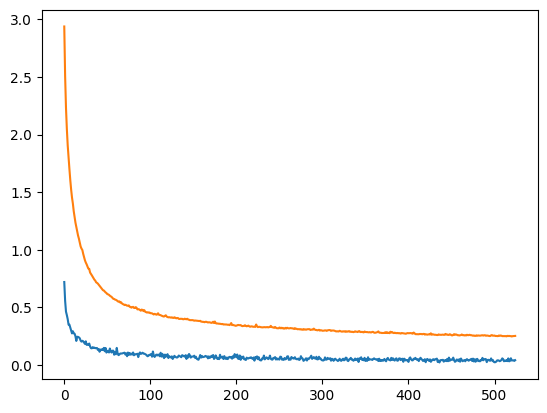

In [ ]:
plt.plot(loss_his)
plt.plot(val_loss_his)
plt.show()

In [71]:
def accuracy(model, test):
    with torch.no_grad():
        model.eval()
        n_correct = 0
        n_total = 0
        for batch_X, batch_y in test:
            outputs = model(batch_X) # batch size x 3
            _, predicted = torch.max(outputs, 1)
            n_total += batch_y.size(0)
            n_correct += (predicted == batch_y).sum().item()

        acc = 100.0 * n_correct / n_total
        print(f'Accuracy of the network on the {len(test)} test samples: {acc} %')

In [72]:
accuracy(model, test_loader)

Accuracy of the network on the 1386 test samples: 96.1976911976912 %
